In [6]:
import warnings
warnings.filterwarnings("ignore")

# loading packages
# basic + dates 
import numpy as np
import pandas as pd
from pandas import datetime

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns # advanced vizs
%matplotlib inline

# statistics
from statsmodels.distributions.empirical_distribution import ECDF

# time series analysis
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# prophet by Facebook
#from fbprophet import Prophet

# machine learning: XGB
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from xgboost.sklearn import XGBRegressor # wrapper

In [9]:
train = pd.read_csv("C:\\Users\\HP\\Downloads\\TSA_Sales Forecast and EDA\\train_store.csv",parse_dates=True,low_memory =False,index_col="Date")

store = pd.read_csv("C:\\Users\\HP\\Downloads\\TSA_Sales Forecast and EDA\\store.csv",
                   low_memory=False)

train.index

DatetimeIndex(['2015-07-31', '2015-07-31', '2015-07-31', '2015-07-31',
               '2015-07-31', '2015-07-31', '2015-07-31', '2015-07-31',
               '2015-07-31', '2015-07-31',
               ...
               '2013-01-01', '2013-01-01', '2013-01-01', '2013-01-01',
               '2013-01-01', '2013-01-01', '2013-01-01', '2013-01-01',
               '2013-01-01', '2013-01-01'],
              dtype='datetime64[ns]', name='Date', length=1017209, freq=None)

In [11]:
train.head(4)

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1
2015-07-31,2,5,6064,625,1,1,0,1
2015-07-31,3,5,8314,821,1,1,0,1
2015-07-31,4,5,13995,1498,1,1,0,1


EDA

In [14]:
print("In total:",train.shape)

train.head(5).append(train.tail(5))

In total: (1017209, 8)


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1
2015-07-31,2,5,6064,625,1,1,0,1
2015-07-31,3,5,8314,821,1,1,0,1
2015-07-31,4,5,13995,1498,1,1,0,1
2015-07-31,5,5,4822,559,1,1,0,1
2013-01-01,1111,2,0,0,0,0,a,1
2013-01-01,1112,2,0,0,0,0,a,1
2013-01-01,1113,2,0,0,0,0,a,1
2013-01-01,1114,2,0,0,0,0,a,1


Short description:

Sales: the turnover for any given day (target variable).
Customers: the number of customers on a given day.
Open: an indicator for whether the store was open: 0 = closed, 1 = open.
Promo: indicates whether a store is running a promo on that day.
StateHoliday: indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays.
SchoolHoliday: indicates if the (Store, Date) was affected by the closure of public schools.
We are dealing with time series data so it will probably serve us to extract dates for further analysis. We also have two likely correlated vaiables in the dataset, which can be combined into a new feature.

In [18]:
train.head(1)

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1


In [19]:
#Date Extraction

train["Year"] = train.index.year
train["Month"] = train.index.month
train["Day"] = train.index.day
train["WeekOfYear"] = train.index.weekofyear

#adding new variables
train["SalePerCustomer"] = train["Sales"]/train["Customers"]
train["SalePerCustomer"].describe()

count    844340.000000
mean          9.493619
std           2.197494
min           0.000000
25%           7.895563
50%           9.250000
75%          10.899729
max          64.957854
Name: SalePerCustomer, dtype: float64

What we infer:
On an average customers spend $9 per day. But there are days with ZERO sales,also.

ECDF : Empirical Cumulative Distribution Function \t
To get the first impression about continuous variables in the data we can
plot ECDF

In [20]:
train.head(2)

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,SalePerCustomer
Date,,,,,,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1,2015,7,31,31,9.482883
2015-07-31,2,5,6064,625,1,1,0,1,2015,7,31,31,9.702400


Text(0.5, 0, 'Sale Per Customer')

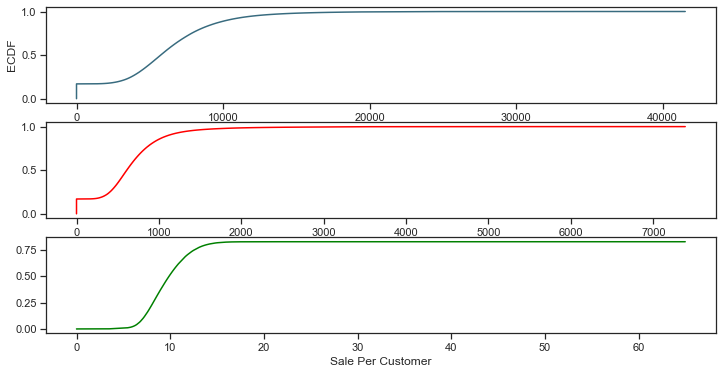

In [25]:
sns.set(style="ticks") #to format into seaborn
c= "#386B7F" #Basic color for plots
plt.figure(figsize=(12,6))

plt.subplot(311)
cdf = ECDF(train["Sales"])
plt.plot(cdf.x,cdf.y,label="statmodels",color=c)
plt.xlabel("Sales")
plt.ylabel("ECDF")

#Plot second ECDF
plt.subplot(312)
cdf = ECDF(train["Customers"])
plt.plot(cdf.x,cdf.y,label="statmodels",color="red")
plt.xlabel("Customers")

#Plot second ECDF
plt.subplot(313)
cdf = ECDF(train["SalePerCustomer"])
plt.plot(cdf.x,cdf.y,label="statmodels",color="green")
plt.xlabel("Sale Per Customer")

About 20% of data has ZERO amount of sales/Customers that we need to deal with
and almost 80% of time daily amount of sales was less than 1000. So what about zero sales,is it only due to the fact that the store was closed?

In [26]:
train.head(3)

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,SalePerCustomer
Date,,,,,,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1,2015,7,31,31,9.482883
2015-07-31,2,5,6064,625,1,1,0,1,2015,7,31,31,9.702400
2015-07-31,3,5,8314,821,1,1,0,1,2015,7,31,31,10.126675


In [29]:
#Closed Stores
#train["Open"] == 0 implies CLOSED Store

subdf = train[(train.Open == 0) & (train.Sales ==0)]
subdf.shape

(172817, 13)

There are 172817 closed stores in the data. It is about 10% of the total amount og observations. To avoid any biased forecasts we will drop these values

What about OPENED stores, but with ZERO sales?

In [30]:
zero_sales = train[(train.Open!=0) & (train.Sales ==0)]
print("In Total:",zero_sales.shape)
zero_sales.head(5)

In Total: (54, 13)


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,SalePerCustomer
Date,,,,,,,,,,,,,
2015-05-15,971,5,0,0,1,0,0,1,2015,5,15,20,NaN
2015-03-26,674,4,0,0,1,0,0,0,2015,3,26,13,NaN
2015-02-05,699,4,0,0,1,1,0,0,2015,2,5,6,NaN
2014-10-01,708,3,0,0,1,1,0,0,2014,10,1,40,NaN
2014-09-22,357,1,0,0,1,0,0,0,2014,9,22,39,NaN


Interestingly enough, there are opened store with no sales on working days. There are
only 54 days in the data, so we can assume that there were external factors involved,
for example manifestations

In [31]:
print("Closed stores and days which didn't have any sales won't be counted into the forecasts.")
train = train[(train["Open"]!=0) & (train["Sales"] !=0)]

print("In Total:",train.shape)

Closed stores and days which didn't have any sales won't be counted into the forecasts.
In Total: (844338, 13)


STORE dataset

In [32]:
#Additional Information about the Stores
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [33]:
store.shape

(1115, 10)

In [37]:
store[:4].T.head(len(store.columns))

,0,1,2,3
Store,1,2,3,4
StoreType,c,a,a,c
Assortment,a,a,a,c
CompetitionDistance,1270,570,14130,620
CompetitionOpenSinceMonth,9,11,12,9
CompetitionOpenSinceYear,2008,2007,2006,2009
Promo2,0,1,1,0
Promo2SinceWeek,NaN,13,14,NaN
Promo2SinceYear,NaN,2010,2011,NaN
PromoInterval,NaN,"Jan,Apr,Jul,Oct","Jan,Apr,Jul,Oct",NaN


Store: a unique Id for each store
StoreType: differentiates between 4 different store models: a, b, c, d
Assortment: describes an assortment level: a = basic, b = extra, c = extended
CompetitionDistance: distance in meters to the nearest competitor store
CompetitionOpenSince[Month/Year]: gives the approximate year and month of the time the nearest competitor was opened
Promo2: Promo2 is a continuing a promotion for some stores: 0 = store is not participating, 1 = store is participating
Promo2Since[Year/Week]: describes the year and calendar week when the store started participating in Promo2
PromoInterval: describes the consecutive intervals Promo2 is started, naming the months the promotion is started. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

In [38]:
#Missing Values
store.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

We have few variables with missing values that we need to deal with. Let's start
with the CompetitionDistance

In [40]:
np.where(store["CompetitionDistance"].isnull())

(array([290, 621, 878], dtype=int64),)

In [41]:
store.CompetitionDistance.describe()

count     1112.000000
mean      5404.901079
std       7663.174720
min         20.000000
25%        717.500000
50%       2325.000000
75%       6882.500000
max      75860.000000
Name: CompetitionDistance, dtype: float64

Apparently this information is simply missing from the data. No particular pattern observed.
In this case, it makes a complete sense to replace NaN with the median values
(Which is twice less than the average)

In [51]:
store.loc[[290,621,878]]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
290,291,d,a,2325.0,NaN,NaN,0,NaN,NaN,NaN
621,622,a,c,2325.0,NaN,NaN,0,NaN,NaN,NaN
878,879,d,a,2325.0,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov"


In [50]:
# fill NaN with a median value(skewed distribution)
store["CompetitionDistance"].fillna(store["CompetitionDistance"].median(),inplace=True)

Continuing further with missing data. What about Promo2SinceWeek? May it be that we
observe unusual data points?

In [54]:
store.head(3)

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"


In [57]:
# no promo = no information about the promo?

_ = store[pd.isnull(store.Promo2SinceWeek)]
_[_.Promo2 !=0].shape

(0, 10)

No, if there's no Promo2 then there's no information about it. We can replace these values by zeros. The same goes for tha variables deducted from the competition, CompetitionOpenSinceMonth and CompetitionOpenSinceYear.

In [60]:
store.fillna(0,inplace=True)

In [61]:
max(store["CompetitionOpenSinceYear"])

2015.0

In [63]:
print("Joining train set and store df to create large Table")

#By specifying inner join we make sure that only those observations
#that are present in both train and store sets are merged together
train_store = pd.merge(train,store,how="inner",on ="Store")

print("In Total:",train_store.shape)
train_store.head()

Joining train set and store df to create large Table
In Total: (844338, 22)


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,...,SalePerCustomer,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,5263,555,1,1,0,1,2015,7,...,9.482883,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,1,4,5020,546,1,1,0,1,2015,7,...,9.194139,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
2,1,3,4782,523,1,1,0,1,2015,7,...,9.143403,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
3,1,2,5011,560,1,1,0,1,2015,7,...,8.948214,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
4,1,1,6102,612,1,1,0,1,2015,7,...,9.970588,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0


In [64]:
train_store[:4].T

,0,1,2,3
Store,1,1,1,1
DayOfWeek,5,4,3,2
Sales,5263,5020,4782,5011
Customers,555,546,523,560
Open,1,1,1,1
Promo,1,1,1,1
StateHoliday,0,0,0,0
SchoolHoliday,1,1,1,1
Year,2015,2015,2015,2015
Month,7,7,7,7


###Store Types
In this section we'll closely look at different levels of StoreType and how the
main metric Sales is distributed among them

In [69]:
train_store.groupby("StoreType")["Sales"].describe()

,count,mean,std,min,25%,50%,75%,max
StoreType,,,,,,,,
a,457042.0,6925.697986,3277.351589,46.0,4695.25,6285.0,8406.00,41551.0
b,15560.0,10233.380141,5155.729868,1252.0,6345.75,9130.0,13184.25,38722.0
c,112968.0,6933.126425,2896.958579,133.0,4916.00,6408.0,8349.25,31448.0
d,258768.0,6822.300064,2556.401455,538.0,5050.00,6395.0,8123.25,38037.0


StoreType B has the highest average of Sales among all others, however we have much less
data for it. So let's print an overall sum of Sales and Customers to see
which StoreType is the most selling and crowded one:

In [73]:
train_store.groupby("StoreType")["Customers","Sales"].sum()

,Customers,Sales
StoreType,,
a,363541431,3165334859
b,31465616,159231395
c,92129705,783221426
d,156904995,1765392943


Clearly stores of type A. StoreType D goes on the second place in both Sales and Customers. What about date periods? Seaborn's facet grid is the best tool for this task:

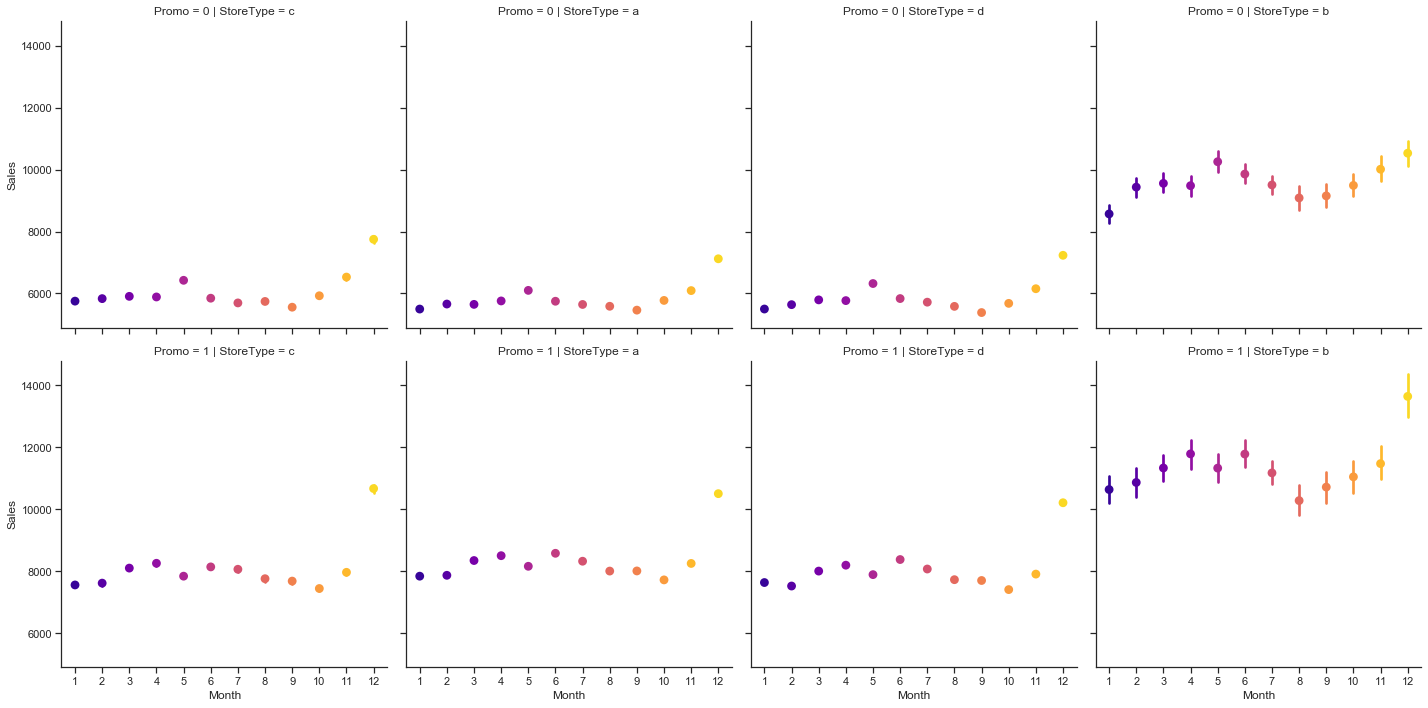

In [74]:
#Sales trends

#Similar to facet_grid in R programming
sns.factorplot(data=train_store,x="Month",y="Sales",
              col = "StoreType",
              palette = "plasma",
              row = "Promo", # Promo = 1 or Promo = 0
              color = c)

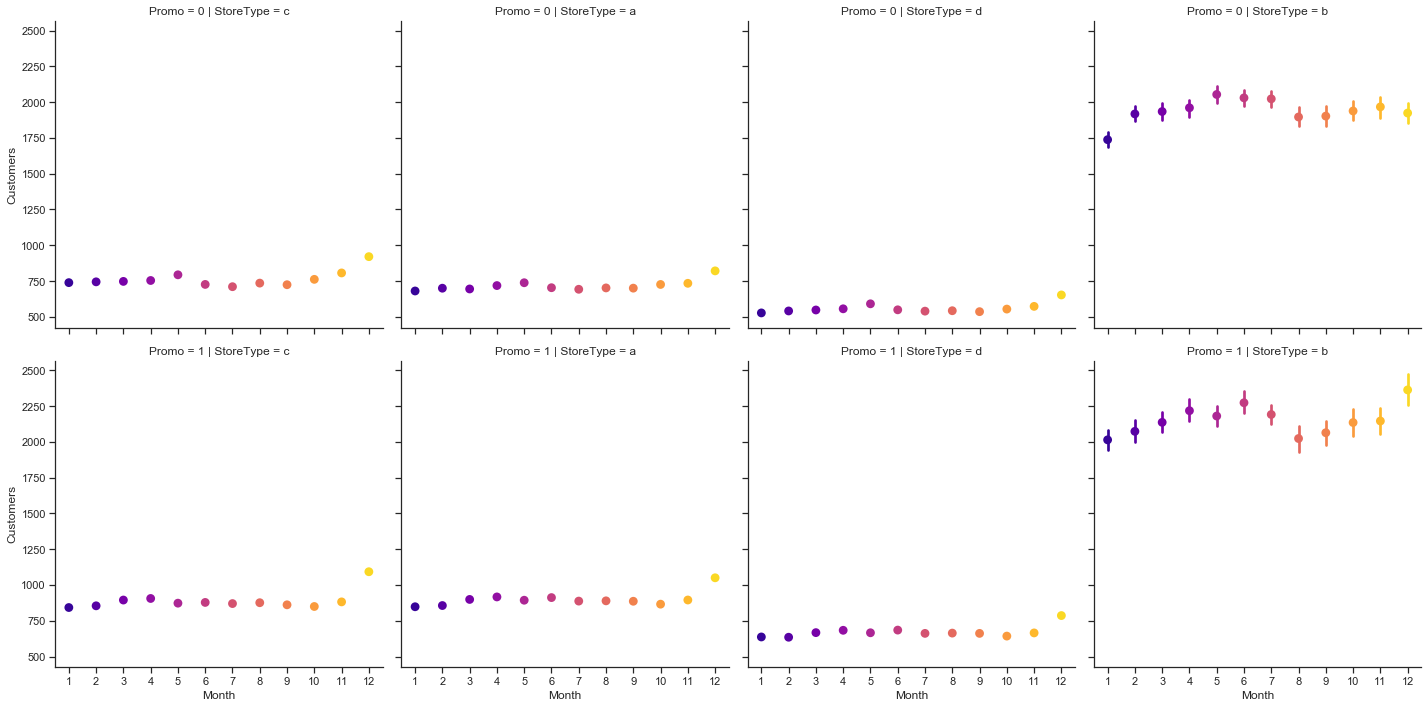

In [75]:
#Customer trend

sns.factorplot(data=train_store,x="Month",y="Customers",
              col="StoreType", # per store type in cols
              palette = "plasma",
              row="Promo", # per promo in the store in rows
              color =c)

All store types follow the same trend but at different scales depending on the presence of the (first) promotion Promo and StoreType itself (case for B).

Already at this point, we can see that Sales escalate towards Christmas holidays. But we'll talk about seasonalities and trends later in the Time Series Analysis section.

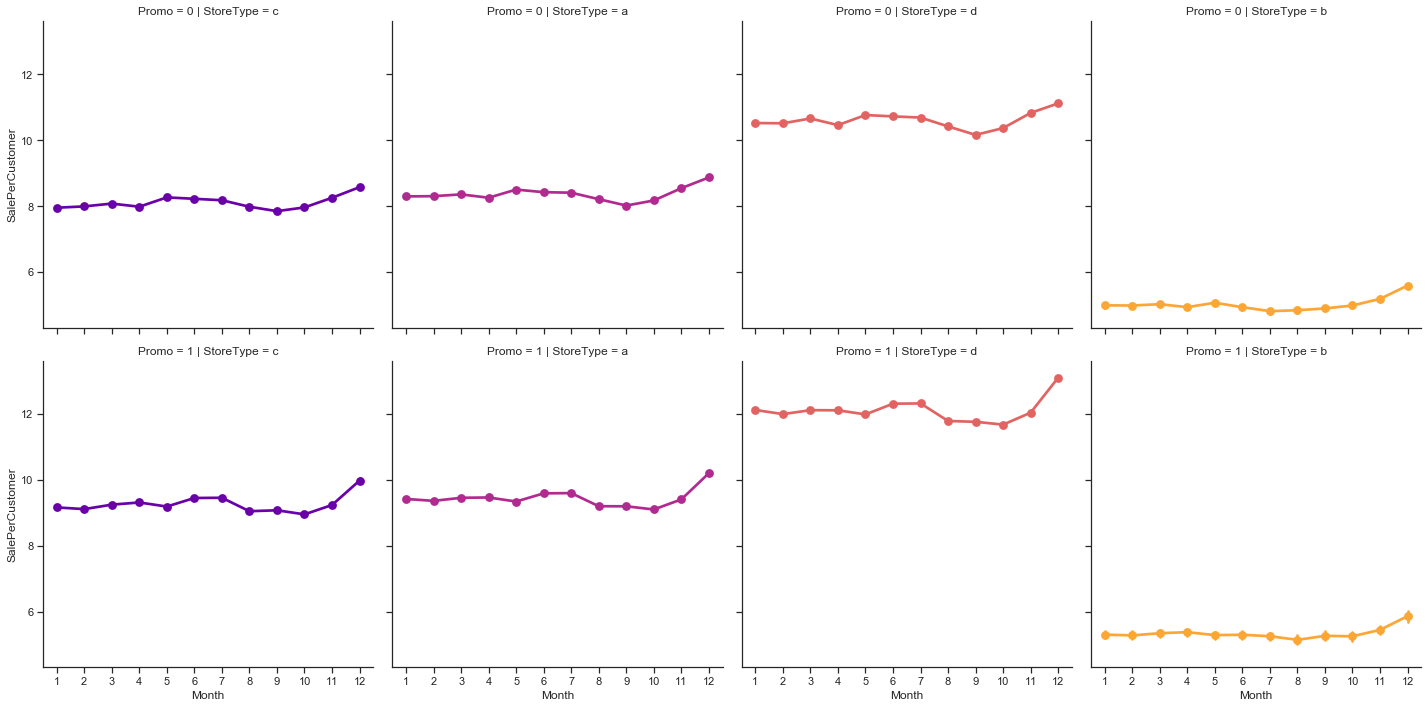

In [77]:
#Sale per customer trends

sns.factorplot(data=train_store,x="Month",y="SalePerCustomer",
              col = "StoreType",
              palette = "plasma",
              hue = "StoreType",
              row ="Promo",
              color = c)

Aha! Eventhough the plots above showed StoreType B as the most selling and performant one, in reality it is not true. The highest SalePerCustomer amount is observed at the StoreType D, about 12€ with Promo and 10€ without. As for StoreType A and C it is about 9€.

Low SalePerCustomer amount for StoreType B describes its Buyer Cart: there are a lot of people who shop essentially for "small" things (or in a little quantity). Plus we saw that overall this StoreType generated the least amount of sales and customers over the period.

In [81]:
train_store.columns

Index(['Store', 'DayOfWeek', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'Year', 'Month', 'Day', 'WeekOfYear',
       'SalePerCustomer', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

<Figure size 1440x360 with 0 Axes>

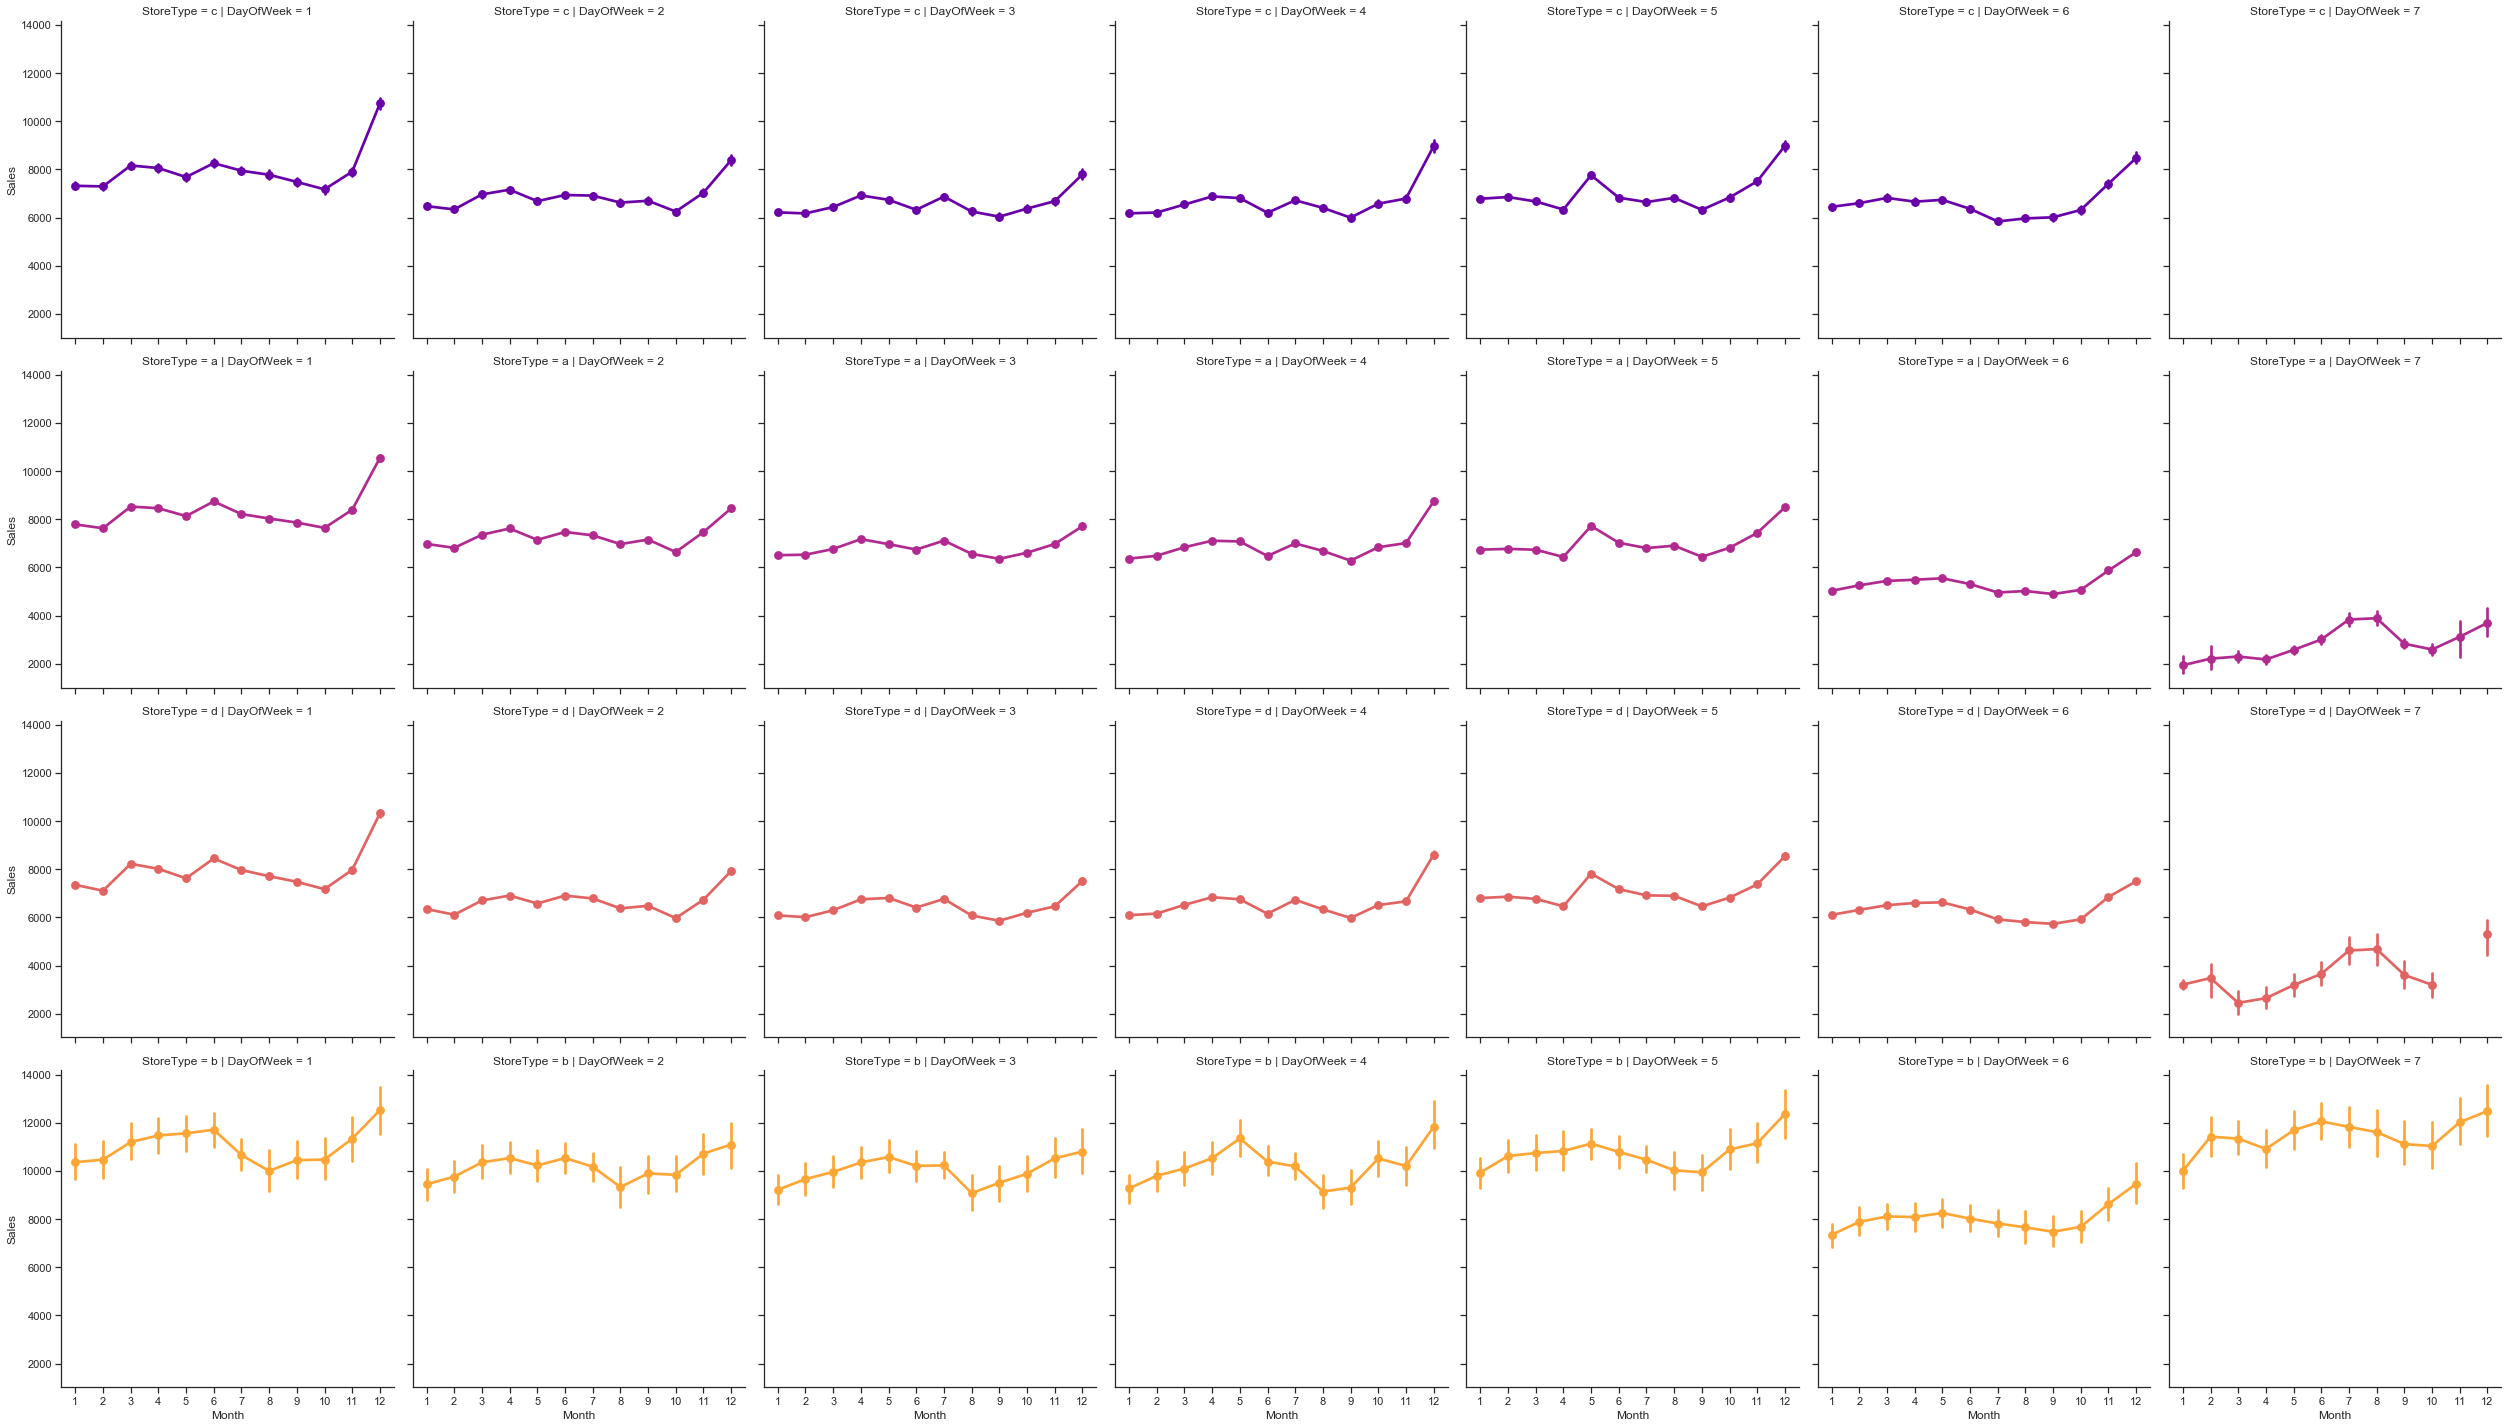

In [83]:
#Customers
plt.figure(figsize=(20,5))
sns.factorplot(data=train_store,x="Month",y="Sales",
              col="DayOfWeek",
              palette = "plasma",
              hue = "StoreType",
              row = "StoreType",
              color = c)

We see that stores of StoreType C are all closed on Sundays, whereas others are most of the time opened. Interestingly enough, stores of StoreType D are closed on Sundays only from October to December.

By the way what are the stores which are opened on Sundays?

In [85]:
# stores that remain opened on Sundays

train_store[(train_store.Open ==1) & (train_store.DayOfWeek ==7)]["Store"].unique()

array([  85,  122,  209,  259,  262,  274,  299,  310,  335,  353,  423,
        433,  453,  494,  512,  524,  530,  562,  578,  676,  682,  732,
        733,  769,  863,  867,  877,  931,  948, 1045, 1081, 1097, 1099],
      dtype=int64)

To complete our preliminary data analysis, we can add variables describing the period of time during which competition and promotion were opened: